In [2327]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2328]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.device(device)

device(type='cpu')

## Loading the Images

In [2329]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("./style_images/style5.jpg")
# content_img = image_loader("./test_images/test1.jpg")
content_img = image_loader("./test_images/test1.jpg")

style_img = transforms.Resize(256)(style_img)
style_img = transforms.CenterCrop((256,256))(style_img)
content_img = transforms.Resize(256)(content_img)
content_img = transforms.CenterCrop((256,256))(content_img)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

## Displaying the Images

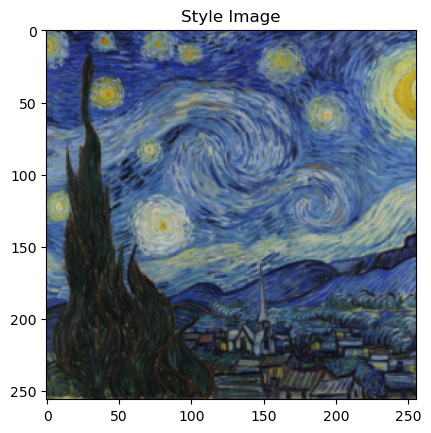

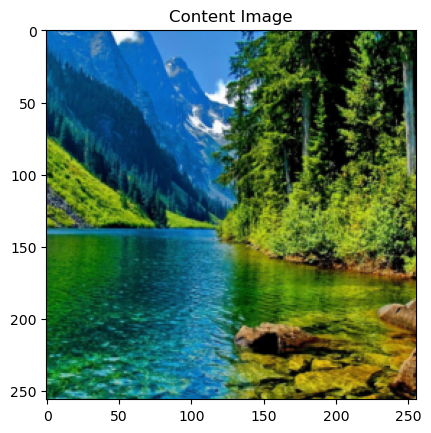

In [2330]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss

In [2331]:
cnn = models.vgg19(pretrained=True).features.eval()

# My Loss

In [2332]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
ACCELERATOR = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import torchvision
from torchmetrics import TotalVariation
import torch.nn as nn

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = mean.clone().detach().view(-1, 1, 1).to(ACCELERATOR)
        self.std = std.clone().detach().view(-1, 1, 1).to(ACCELERATOR)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std


class LossCNN(nn.Module):
    def __init__(self, content_layers, style_layers, **kwargs):
        super().__init__()
        self.kwargs = kwargs
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.vgg16 = torchvision.models.vgg16(pretrained=True, progress=True).features.to(ACCELERATOR)
        self.vgg16.eval()
        # for param in self.vgg16.parameters(): # freeze the vgg16 model
        #     param.requires_grad = False
        self.normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(ACCELERATOR)
        # may be worth to check if trimming the vgg16 model to only the layers we need is worth it
    
    def forward(self, x):
        content_activations = []
        style_activations = []
        x = x.to(ACCELERATOR)
        
        x = self.normalization(x)
        j = 0
        for layer in self.vgg16.children():
            
            if isinstance(layer, nn.Conv2d):
                j += 1
                name = 'conv_{}'.format(j)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(j)
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(j)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(j)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
            
            x = layer(x)
            
            if name in self.content_layers:
                # print(name)
                content_activations.append(x)

            if name in self.style_layers:
                # print(name)
                style_activations.append(x)
                
        return content_activations, style_activations
    

class LossCalculator():
    def __init__(self, **kwargs):
        self.mse = torch.nn.MSELoss(reduction='sum').to(ACCELERATOR)
        self.content_layers = ['relu_7'] # use conv4_2
        self.style_layers = ['relu_2', 'relu_4', 'relu_7', 'relu_10'] # conv1_2, conv2_2, conv3_3, conv4_3
        # self.style_layers = ['relu_13']
        self.loss_net = LossCNN(self.content_layers, self.style_layers)
        self.tv = TotalVariation().to(ACCELERATOR)
        
        self.style_image_style_activations = None
        
        
    def _total_variation_reg(self, x):
        return torch.mean(self.tv(x)) # b, c, h, w -> b, 1 -> 1
    
    # def _style_loss(self, x, y): # loss implementation from ulyanov et al.
    #     b, c, h, w = x.shape
    #     F_x = x.view(b, c, h * w)
    #     F_y = y.view(b, c, h * w)
        
    #     G_x = torch.bmm(F_x, F_x.transpose(-1, -2))
    #     G_x = torch.div(G_x, c * h * w)
    #     G_y = torch.bmm(F_y, F_y.transpose(-1, -2))
    #     G_y = torch.div(G_y, c * h * w)
        
    #     G_diff = G_x - G_y # b, c, c
    #     G_diff_square = torch.mul(G_diff, G_diff) # b, c, c
    #     return torch.sum(G_diff_square).div(b) # b, c, c -> 1 (div by b to get mean)


    # def _feature_loss(self, x, y):
    #     b, c, h, w = x.shape
    #     F_x = x.view(b, c, h * w)
    #     F_y = y.view(b, c, h * w)
        
    #     # torch.nn.mse hätts auch getan
    #     F_diff = F_x - F_y # b, c, h * w
    #     F_diff_square = torch.mul(F_diff, F_diff) # b, c, h * w
    #     loss = torch.sum(F_diff_square).div(b * c * h * w) # b, c, h * w -> 1 (div by b to get mean)
    #     return loss
    
    def _gram_matrix(self, x):
        b, c, h, w = x.shape
        x = x.view(b, c, h*w) 
        return torch.bmm(x, x.transpose(-1, -2)).div(c * h * w) # b,c, h*w -> b, c, c

    def _style_loss(self, x, y):
        b, c, h, w = x.shape
        gram_x = self._gram_matrix(x) # b, c, c
        gram_y = self._gram_matrix(y) # b, c, c
        return self.mse(gram_y, gram_x).div(b * 4) # b, c, c -> 1

    def _feature_loss(self, x, y):
        b, c, h, w = x.shape
        return self.mse(x, y).div(b * c * h * w * 2) # b, c, h, w -> 1

    def calculate_loss(self, alpha, beta, gamma, generated_image, style_image, original_image):
        style_image = style_image.to(ACCELERATOR)
        original_image = original_image.to(ACCELERATOR)
        generated_content_activations, generated_style_activations = self.loss_net(generated_image)
        
        # style_loss_weights = [0.8, 0.3, 0.03, 0.03, 0.03]
        style_loss_weights = [1.0, 1.0, 1.0, 1.0, 1.0]
        
        original_content_activations = None
        with torch.no_grad(): # the style image and content activations are not generated by the model so we don't need to track gradients
            original_content_activations, _ = self.loss_net(original_image)
            if self.style_image_style_activations is None or \
                generated_style_activations[0].shape != self.style_image_style_activations[0].shape:
                _, self.style_image_style_activations = self.loss_net(style_image)

        # Feature Loss
        content_losses = torch.zeros(len(self.content_layers), device=ACCELERATOR)
        for i in range(len(self.content_layers)):
            content_losses[i] = self._feature_loss(generated_content_activations[i], original_content_activations[i])
        content_loss = torch.sum(content_losses)
        
        # Style Loss
        style_losses = torch.zeros(len(self.style_layers), device=ACCELERATOR)
        for i in range(len(self.style_layers)):
            style_losses[i] = style_loss_weights[i] * self._style_loss(
                generated_style_activations[i], 
                torch.zeros(generated_style_activations[i].shape, device=ACCELERATOR) + self.style_image_style_activations[i]
            )
        style_loss = torch.sum(style_losses)
        
        # Total Variation Regularization
        total_var_reg = self.tv(generated_image)
        
        loss = alpha * content_loss + beta * style_loss + gamma * total_var_reg

        return loss

Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. We will use them to normalize the image before sending it into the network.

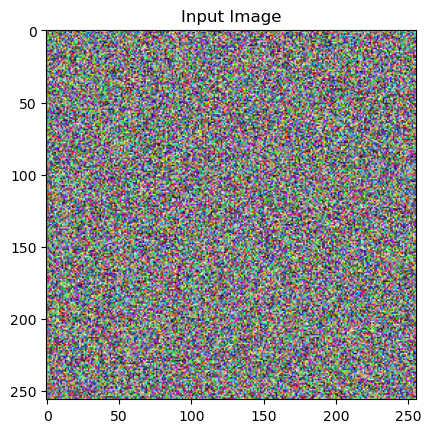

In [2333]:
# input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [2334]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [2335]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=100, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    lc = LossCalculator()
     

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            loss = lc.calculate_loss(content_weight, style_weight, 1e-4, input_img, style_img, content_img)
            loss.backward()

            run[0] += 1
            if run[0] % 5 == 0:
                print("run {}:".format(run))
                print('Loss : {:4f}'.format(loss.item()))

            return loss

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [5]:
Loss : 2606.510742
run [10]:
Loss : 265.587616
run [15]:
Loss : 185.211349
run [20]:
Loss : 153.848358
run [25]:
Loss : 137.824158
run [30]:
Loss : 126.572159
run [35]:
Loss : 113.796684
run [40]:
Loss : 104.832001
run [45]:
Loss : 91.631119
run [50]:
Loss : 82.371292
run [55]:
Loss : 71.092598
run [60]:
Loss : 60.853012
run [65]:
Loss : 55.391201
run [70]:
Loss : 49.804321
run [75]:
Loss : 44.640480
run [80]:
Loss : 40.573914
run [85]:
Loss : 36.824314
run [90]:
Loss : 33.830025
run [95]:
Loss : 31.724575
run [100]:
Loss : 29.679264
run [105]:
Loss : 28.137041
run [110]:
Loss : 26.666704
run [115]:
Loss : 25.203972
run [120]:
Loss : 24.245558
run [125]:
Loss : 23.453911
run [130]:
Loss : 22.782604
run [135]:
Loss : 22.249321
run [140]:
Loss : 21.803318
run [145]:
Loss : 21.430141
run [150]:
Loss : 21.085665
run [155]:
Loss : 20.802116
run [160]:
Loss : 20.540905
run [165]:
Loss : 20.316822
run [170]:
Loss : 20.129017
run [175]:

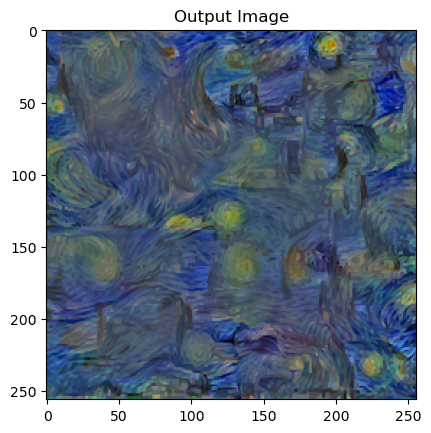

In [2336]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()